In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, f1_score, fbeta_score, make_scorer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.compose import make_column_transformer

from xgboost import XGBClassifier



pd.set_option('display.float_format', lambda x: '%.2f' % x)
RSEED = 42

In [2]:
df = pd.read_csv('data/cleaned/train.csv')
df_test = pd.read_csv('data/cleaned/test.csv')
df.head()


,district,client_id,client_catg,region,target,reading_remarque,counter_coeff,consommation_per_month,months_number,elec,gaz
0,63,train_Client_33962,11,101,0.00,6.00,1.00,113.27,4.00,1,1
1,62,train_Client_32174,11,301,0.00,6.00,1.00,8.11,3.40,1,1
2,69,train_Client_18868,11,107,0.00,6.00,1.00,70.77,4.00,1,1
3,62,train_Client_39728,11,310,0.00,6.00,1.00,144.65,4.11,1,0
4,60,train_Client_34246,11,101,0.00,6.00,1.00,120.93,3.96,1,1


## Split Target, Drop ID

In [3]:
y_train = df['target']
X_train = df.drop(['target', 'client_id'], axis=1)

In [4]:
# Helper: Check specific columns:
X_train.iloc[:,5].sort_values(ascending=False).nunique()

105312

In [5]:
# Helper (compare X_train and X_test below):
X_train.head(2)

,district,client_catg,region,reading_remarque,counter_coeff,consommation_per_month,months_number,elec,gaz
0,63,11,101,6.00,1.00,113.27,4.00,1,1
1,62,11,301,6.00,1.00,8.11,3.40,1,1


In [6]:
#Split target from test data
y_test = df_test['target']
X_test = df_test.drop(['target'], axis=1)

In [7]:
# Helper (compare X_train and X_test):
X_test.head(2)

,district,client_catg,region,reading_remarque,counter_coeff,consommation_per_month,months_number,elec,gaz
0,69,11,104,8.00,1.00,52.00,4.00,1,0
1,62,11,301,6.00,1.00,117.75,4.00,1,0


## Scaling the data

<Axes: xlabel='consommation_per_month', ylabel='Count'>

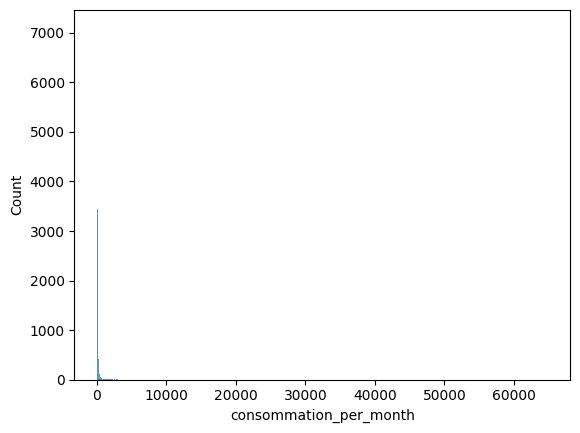

In [8]:
sns.histplot(X_train['consommation_per_month'])

<Axes: xlabel='months_number', ylabel='Count'>

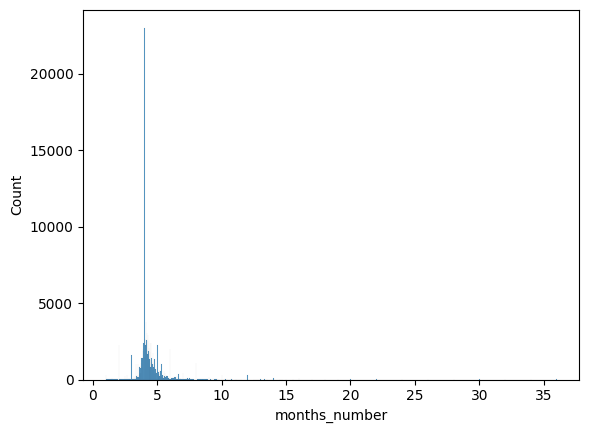

In [9]:
sns.histplot(X_train['months_number'])

<span style='color:red'> Do we want to scale all date? eg. district, client_catg, region, reading_remarque, elec + gaz? Those are more or less categorical values right? So maybe it makes sense to make a **column-transformer**?</span>

- lot's of consommation = 0? What to do?

In [10]:
# numerical features
num_features = [ 'consommation_per_month', 'months_number']
num_transformer = make_pipeline(
        MinMaxScaler() # no gaussian distribution? 
    )

In [11]:
preprocessor = make_column_transformer(
        (num_transformer, num_features)
)

In [12]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

## Hybrid Sampling (Undersampling of Non-Fraud and Oversampling of Fraud cases)

In [13]:
# SMOTE + ENN (Noise Reduction)
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

In [32]:
# 1. Under sampling of the majority
#under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Reduces 50% of the Non-Fraud cases
#X_train_undersampled, y_train_undersampled = under.fit_resample(X_train, y_train)

# 2. Over sampling of the minority
#smote = SMOTE(sampling_strategy=0.7, random_state=42)  # brings the minority class to 70% of the majority
#X_train_resampled, y_resampled = smote.fit_resample(X_train_undersampled, y_train_undersampled)

In [15]:
X_resampled.shape

(189119, 9)

In [16]:
y_resampled.shape

(189119,)

<Axes: xlabel='target', ylabel='count'>

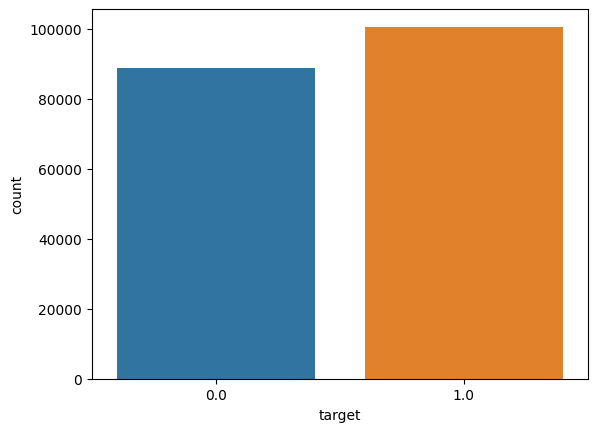

In [18]:
# handling the imbalanced
#ros = RandomOverSampler(random_state=RSEED)
#X_train, y_train = ros.fit_resample(X_train, y_train)

sns.countplot(x=y_resampled)

## HyperparameterSearch & Scoring


In [19]:
scoring = make_scorer(fbeta_score, beta=2)
cv = 5 #RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

## Model 1: Random Forest

#### with RandomizedSearch
<span style="color:red"> Caution Grid search tooks very very long!</span>


In [20]:
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=RSEED))]
)

In [21]:
# don't forget to add the name of the model from the pipelin in front of each hyperparameter!
param_rf = {'rf__n_estimators': [50, 100, 500, 750, 1000, 1500, 2000],
    'rf__max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'rf__max_leaf_nodes': [None] + list(np.arange(10, 51).astype(int)),
    'rf__min_samples_split': [2, 5, 10],
    'rf__max_depth': [None] + [10, 50, 100],
    'rf__bootstrap': [True, False],
    'rf__criterion': ['entropy', 'gini']
    }

randomsearch_rf = RandomizedSearchCV(pipe_rf, param_distributions=param_rf, cv=cv, scoring=scoring, n_iter=10,
                           verbose=5, n_jobs=-1) #evt. add error_score='raise'

In [22]:
randomsearch_rf.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\Maria\Desktop\neuefische\my_ml_project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Maria\Desktop\neuefische\my_ml_project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Maria\Desktop\neuefische\my_ml_project\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Maria\Desktop\n

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('pipeline',
                                                                               Pipeline(steps=[('minmaxscaler',
                                                                                                MinMaxScaler())]),
                                                                               ['consommation_per_month',
                                                                                'months_number'])])),
                                             ('rf',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__criterion': ['entropy', 'gini']...
                                        'rf__max_features': ['auto', 'sqrt',
                                                             None, 0.5, 0.6,
                                                             0.7,
                                                             0.7999999999999999,
                                                             0.8999999999999999],
                                        'rf__max_leaf_nodes': [None, 10, 11, 12,
                                                               13, 14, 15, 16,
                                                               17, 18, 19, 20,
                                                               21, 22, 23, 24,
                                                               25, 26, 27, 28,
                                                               29, 30, 31, 32,
                                                               33, 34, 35, 36,
                                                               37, 38, ...],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [50, 100, 500, 750,
                                                             1000, 1500,
                                                             2000]},
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
                   verbose=5)

In [23]:
# Show best parameters
print('Best score:\n{:.2f}'.format(randomsearch_rf.best_score_))
print("Best parameters:\n{}".format(randomsearch_rf.best_params_))

Best score:
0.83
Best parameters:
{'rf__n_estimators': 750, 'rf__min_samples_split': 10, 'rf__max_leaf_nodes': 47, 'rf__max_features': 'sqrt', 'rf__max_depth': 10, 'rf__criterion': 'entropy', 'rf__bootstrap': True}


In [24]:
# Save best model (including fitted preprocessing steps) as best_model_rf 
best_model_rf = randomsearch_rf.best_estimator_
best_model_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['consommation_per_month',
                                                   'months_number'])])),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        max_leaf_nodes=47, min_samples_split=10,
                                        n_estimators=750, random_state=42))])

In [25]:
# Make predictions for X_train
train_probs_1 = best_model_rf.predict_proba(X_train)[:, 1]
train_predictions_1 = best_model_rf.predict(X_train)

# Results X_train prediction:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs_1)}')
print(confusion_matrix(y_train, train_predictions_1))
print(classification_report(y_train, train_predictions_1))

Train ROC AUC Score: 0.6451696841324778
[[55505 70883]
 [ 1664  5888]]
              precision    recall  f1-score   support

         0.0       0.97      0.44      0.60    126388
         1.0       0.08      0.78      0.14      7552

    accuracy                           0.46    133940
   macro avg       0.52      0.61      0.37    133940
weighted avg       0.92      0.46      0.58    133940



In [26]:
# make predictions for X-test
test_probs_1 = best_model_rf.predict_proba(X_test)[:, 1]
test_predictions_1 = best_model_rf.predict(X_test)

# Results X_test prediction:
print(f'Test ROC AUC Score: {roc_auc_score(y_test, test_probs_1)}')
print(confusion_matrix(y_test, test_predictions_1))
print(classification_report(y_test, test_predictions_1))

Test ROC AUC Score: 0.5267849208803093
[[1016727   13782]
 [  86326    1887]]
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95   1030509
         1.0       0.12      0.02      0.04     88213

    accuracy                           0.91   1118722
   macro avg       0.52      0.50      0.49   1118722
weighted avg       0.86      0.91      0.88   1118722



#### Without GridSearch

In [ ]:
# Create the model with 1000 trees
model1 = RandomForestClassifier(n_estimators=1000, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model1.fit(X_train, y_train)

In [ ]:
# Make predictions for X_train
train_probs_1 = model1.predict_proba(X_train)[:, 1]
train_predictions_1 = model1.predict(X_train)

In [ ]:
# Results X_train prediction:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs_1)}')
print(confusion_matrix(y_train, train_predictions_1))
print(classification_report(y_train, train_predictions_1))

In [ ]:
# Make predictions for X_test
test_probs_1 = model1.predict_proba(X_test)[:, 1]
test_predictions_1 = model1.predict(X_test)

In [ ]:
# Results X_test prediction:
print(f'Test ROC AUC Score: {roc_auc_score(y_test, test_probs_1)}')
print(confusion_matrix(y_test, test_predictions_1))
print(classification_report(y_test, test_predictions_1))